In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

In [3]:

names = ['g', 'P', 'rho', 'r', 'T', 'Tm', 'Cp', 'alpha', 'gamma', 'Kt', 'Ka', 'G', 'sigma', 'phase']

titles =  [
    'Gravity', 'Pressure', 'Density', 'Temperature', 'Melt Temperature', 'Heat Capacity',
    'Thermal Expansivity', 'Grüneisen Parameter', 'Isothermal Bulk Modulus', 
    'Adiabatic Bulk Modulus', 'Shear Modulus', 'Electrical Conductivity', 'Material Phase Number'
]

#'M1_Fe30_sFe6-5_pprofs.res', 'M1_Fe60_sFe6-5_pprofs.res', 'M2_Fe30_sFe6-5_pprofs.res',
#'M2_Fe60_sFe6-5_pprofs.res', 'M3_Fe30_sFe6-5_pprofs.res', 'M3_Fe60_sFe6-5_pprofs.res',
#'M4_Fe30_sFe6-5_pprofs.res', 'M4_Fe60_sFe6-5_pprofs.res', 'M5_Fe30_sFe6-5_pprofs.res',
#'M5_Fe60_sFe6-5_pprofs.res',  

profs = [
    'M1_Fe32-5_wSi010_M000.res', 'M1_Fe32-5_wSi020_M000.res', 'M1_Fe32-5_wSi030_M000.res', 
    'M1_Fe32-5_wSi040_M000.res', 'M1_Fe32-5_wSi050_M000.res', 'M1_Fe32-5_wSi060_M000.res', 
    'M1_Fe32-5_wSi070_M000.res', 'M1_Fe32-5_wSi080_M000.res', 'M1_Fe32-5_wSi090_M000.res', 
    'M1_Fe32-5_wSi100_M000.res', 'M1_Fe32-5_wSi110_M000.res', 'M1_Fe32-5_wSi120_M000.res', 
    'M1_Fe32-5_wSi130_M000.res', 'M1_Fe32-5_wSi140_M000.res', 'M1_Fe32-5_wSi150_M000.res'
]

lbl = []
for prof in profs:
    str = prof[0:16]
    str = str.replace('_', ' ')
    str = str.replace('Fe','CMF')
    str = str.replace('-','.')
    lbl.append(str)

cmap = cm['cividis']
clrs = cmap(np.linspace(0,1,len(profs)))

# from profs.res load the data as a dataframe with 14 columns that are delimitered by whitespace
planets = {}
cores = {}
labels = {}
for prof in profs:
    df = pd.read_csv(prof,delimiter=r'\s+', names=names)
    for i in range(len(df['phase'])):
        if df['phase'][i] == 8.0:
            cmb = i
            # delete all values after index cmb
            break
    i = profs.index(prof)
    prof = prof[0:16]
    df['P'] = df['P']*1.0e9
    df['alpha'] = df['alpha']*1.0e-5

    planets[prof] = df
    labels[prof] = lbl[i]

    df = df.drop(df.index[:cmb])
    # convert the index from 0 to 511
    ncmb = 1000-cmb
    df.index = range(0,ncmb)
    reverse = df[::-1]
    # corrections
    df['n'] = ncmb
    df['r'] = df['r']-df['r'][ncmb-1]
    cores[prof] = df

print(planets.keys())

dict_keys(['M1_Fe32-5_wSi010', 'M1_Fe32-5_wSi020', 'M1_Fe32-5_wSi030', 'M1_Fe32-5_wSi040', 'M1_Fe32-5_wSi050', 'M1_Fe32-5_wSi060', 'M1_Fe32-5_wSi070', 'M1_Fe32-5_wSi080', 'M1_Fe32-5_wSi090', 'M1_Fe32-5_wSi100', 'M1_Fe32-5_wSi110', 'M1_Fe32-5_wSi120', 'M1_Fe32-5_wSi130', 'M1_Fe32-5_wSi140', 'M1_Fe32-5_wSi150'])


In [4]:
data_PREM = np.genfromtxt('PREM500.csv', delimiter=',', skip_header=1)
PREM_r = data_PREM[:,0]
PREM_rho = data_PREM[:, 1]
# Define new radius values (for example, n=1000)
n=len(planets[prof]['r'])
r = np.linspace(min(PREM_r), max(PREM_r), n)
G = 6.6743e-11

# Interpolate density to the new radius values
density_interpolator = sp.interpolate.interp1d(PREM_r, PREM_rho, kind='linear', fill_value="extrapolate")
rho = density_interpolator(r)

# Initialize arrays for mass, gravitational acceleration, and pressure
M = np.zeros_like(r)
g = np.zeros_like(r)
P = np.zeros_like(r)

# Compute mass, gravitational acceleration, and pressure
for i in range(1, len(r)):
    # Integrate mass up to radius r[i] using the trapezoidal rule
    M[i] = 4 * np.pi * np.trapz(rho[:i+1] * r[:i+1]**2, r[:i+1])
    
    # Compute gravitational acceleration at radius r[i]
    g[i] = G * M[i] / r[i]**2
    
    # Compute pressure at radius r[i] using hydrostatic equilibrium
    P[i] = P[i-1] + np.trapz(-rho[i-1:i+1] * g[i-1:i+1], r[i-1:i+1])

P = (P-P[-1])/1e9 # [GPa]

# find r core where g is maximum
rc = r[np.argmax(g)]

# find the density jump at the inner core boundary where rho suddenly increases
ri = r[np.argmax(-1*np.gradient(rho[:np.argmax(g)]))]

planets['PREM'] = pd.DataFrame({'r': r, 'rho': rho, 'g': g, 'P': P})

def V(r):
    return 4/3*np.pi*(r)**3

prof = 'M1_Fe32-5_wSi010'
x0 = 0.11
x_ini = x0-x0*V(ri)/V(rc) #earth
rc_p = cores[prof]['r'][0]
for i in range(len(cores[prof]['r'])-1,0,-1):
    if cores[prof]['r'][i] > ri:
        ri_p = cores[prof]['r'][i]
        break
cores[prof]['x0'] = x_ini*V(rc)/(V(rc)-V(ri))

print(f"Earth Core radius: {rc} m")
print(f"Earth Inner core radius: {ri} m")
print(f'Inner core radius of earth {ri/rc:.2%}')
print(f'Initial concetration of light elements in earth {x_ini:.2%}')
print(x_ini)
print()
print(f"Core radius: {rc_p} m")
print(f"Inner core boundary: {ri_p} m")
print(f'Inner core volume of {prof} {ri_p**3/rc_p**3:.2%}')
print(f'Outer core concentration of {prof} {x_ini*V(rc_p)/(V(rc_p)-V(ri_p)):.2%}')

Earth Core radius: 3481514.046046046 m
Earth Inner core radius: 1215749.7297297297 m
Inner core radius of earth 34.92%
Initial concetration of light elements in earth 10.53%
0.10531595805731145

Core radius: 3364242.6277063 m
Inner core boundary: 1218301.0986363 m
Inner core volume of M1_Fe32-5_wSi010 4.75%
Outer core concentration of M1_Fe32-5_wSi010 11.06%


Planet Radius: 6362438.411568 m
Earth Radius: 6371000.0 m
Core Mass Fraction: 32.41%


C:\Users\louis\AppData\Local\Temp\ipykernel_21944\3888076802.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r+" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ri_p/1000, cores[sim]['rho'][i], 'r+', color=clrs[profs.index(prof)], alpha = 0.5)


Core Mass Fraction: 33.04%
Core Mass Fraction: 32.41%
Core Mass Fraction: 32.41%
Core Mass Fraction: 32.41%
Core Mass Fraction: 32.41%
Core Mass Fraction: 32.41%
Core Mass Fraction: 36.82%
Core Mass Fraction: 33.04%
weight fraction: 93% Fe, 7% Si
Molar Fraction: 86.98% Fe, 13.02% Si


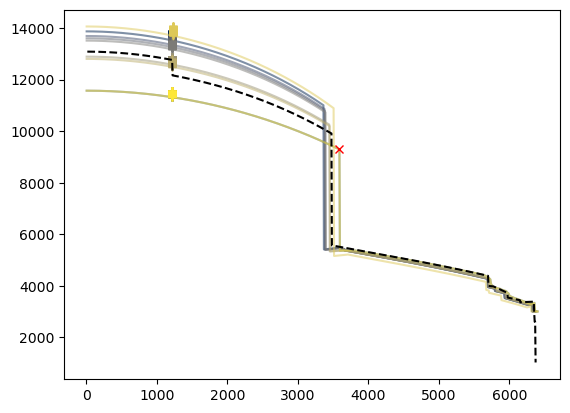

In [14]:
sim = 'M1_Fe37-7_wSi010'
print(f'Planet Radius: {planets[sim]['r'][0]} m')
print(f'Earth Radius: {planets['PREM']['r'][999]} m')

Ticb, Tcmb = [], []
for prof in profs:
    sim = prof[0:16]
    plt.plot(planets[sim]['r']/1000, planets[sim]['rho'], label=labels[sim], color=clrs[profs.index(prof)], alpha = 0.5, linestyle='-')
    for i in range(len(cores[sim]['r'])-1,0,-1):
        if cores[sim]['r'][i] > ri:
            ri_p = cores[sim]['r'][i]
            Ticb.append(cores[sim]['T'][i])
            break
        Tcmb.append(cores[sim]['T'][0])
        plt.plot(ri_p/1000, cores[sim]['rho'][i], 'r+', color=clrs[profs.index(prof)], alpha = 0.5)
    
    m = 0 
    for i in range(1,len(planets[sim]['r'])-1):
        m += 4/3*np.pi*(planets[sim]['r'][i-1]**3-planets[sim]['r'][i]**3)*planets[sim]['rho'][i]

    m_c = 0
    for i in range(1,len(cores[sim]['r'])-1):
        m_c += 4/3*np.pi*(cores[sim]['r'][i-1]**3-cores[sim]['r'][i]**3)*cores[sim]['rho'][i]
    print(f'Core Mass Fraction: {m_c/m:.2%}')

plt.plot(planets['PREM']['r']/1000, planets['PREM']['rho'], label='PREM', color='black', linestyle='--')
plt.plot(cores[sim]['r'][0]/1000, cores[sim]['rho'][0], 'rx', label='Core-Mantle Boundary')

XFe = (93/55.845)/(93/55.845 + 7/28.0855)  # Molar fraction Fe-7Si
XSi = 1.0 - XFe  # Molar fraction Fe-7Si
print(f'weight fraction: 93% Fe, 7% Si')
print(f'Molar Fraction: {XFe:.2%} Fe, {XSi:.2%} Si')